In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import random
import numpy as np
import glob
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

import torch
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [2]:
# set the seed
SEED = 1234
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
#tf.random.set_seed(SEED)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
# https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/11-vision-transformer.html
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### csv with filenames and labels

In [3]:
images = glob.glob("D://DATASETS/DogsVsCats/train-val-test/*.jpg")
len(images)

25000

In [4]:
labels = [1 if "dog" in fname else 0 for fname in images]
full_df = pd.DataFrame()
full_df["filename"] = images
full_df["label"] = labels
full_df[:3]

,filename,label
0,D://DATASETS/DogsVsCats/train-val-test\cat.0.jpg,0
1,D://DATASETS/DogsVsCats/train-val-test\cat.1.jpg,0
2,D://DATASETS/DogsVsCats/train-val-test\cat.10.jpg,0


### Shuffle dataframe

In [5]:
full_df = full_df.sample(frac=1).reset_index()
full_df[:5]

,index,filename,label
0,5262,D://DATASETS/DogsVsCats/train-val-test\cat.348...,0
1,22764,D://DATASETS/DogsVsCats/train-val-test\dog.798...,1
2,2633,D://DATASETS/DogsVsCats/train-val-test\cat.123...,0
3,22512,D://DATASETS/DogsVsCats/train-val-test\dog.776...,1
4,19404,D://DATASETS/DogsVsCats/train-val-test\dog.496...,1


In [6]:
full_df.label.sum()

12500

In [7]:
import numpy as np

dogs_df = full_df[full_df.label==1].sample(frac=1).reset_index(drop=True)
cats_df = full_df[full_df.label==0].sample(frac=1).reset_index(drop=True)

dogs = {"train":None, "test": None, "valid":None}
cats = {"train":None, "test": None, "valid":None}

dogs["train"], dogs["test"], dogs["valid"] = np.split(dogs_df, [int(0.8*len(dogs_df)), int(0.9*len(dogs_df))])
cats["train"], cats["test"], cats["valid"] = np.split(cats_df, [int(0.8*len(cats_df)), int(0.9*len(cats_df))])

train_df = pd.concat([dogs["train"], cats["train"]]).sample(frac=1).reset_index(drop=True)
test_df = pd.concat([dogs["test"], cats["test"]]).sample(frac=1).reset_index(drop=True)
valid_df = pd.concat([dogs["valid"], cats["valid"]]).sample(frac=1).reset_index(drop=True)

In [8]:
len(train_df), len(test_df), len(valid_df)

(20000, 2500, 2500)

In [9]:
train_df[:3]

,index,filename,label
0,1550,D://DATASETS/DogsVsCats/train-val-test\cat.113...,0
1,19077,D://DATASETS/DogsVsCats/train-val-test\dog.466...,1
2,5690,D://DATASETS/DogsVsCats/train-val-test\cat.387...,0


In [10]:
train_df.label.sum()

10000

### `Dataset` stores the samples and their corresponding labels, and `DataLoader` wraps an iterable around the Dataset to enable easy access to the samples.

#### https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler
#### https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset

### TODO: Sampler

#### https://pytorch.org/docs/stable/data.html#torch.utils.data.Sampler

In [11]:
class CustomImageDataset(Dataset):
    '''
    https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
    '''
    def __init__(self, dataframe, transform=None, target_transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.filename[idx]
        # read JPEG or PNG image from filepath  --> output (Tensor[image_channels, image_height, image_width])
        image =  read_image(img_path) #outputs a tensor
        label =  self.dataframe.label[idx]
        
        if self.transform:
            # These are transformation single level
            image = self.transform(image)
            
        if self.target_transform:
            label = self.target_transform(label)
            
        return {'image': image, 'label': label}  #image, label

### https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [12]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h + 1)
        left = np.random.randint(0, w - new_w + 1)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}
        
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'label': torch.from_numpy(label)}


class Normalize(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, image):

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = 2*(image/255.0) - 1 # between -1 and +1
        return image

In [13]:
from torchvision import transforms

transforms_train = transforms.Compose([Normalize(),
                                transforms.Resize(256),
                               transforms.RandomCrop(224)
                                ])

In [14]:
train_ds = CustomImageDataset(train_df,transform=transforms_train)
train_ds

In [15]:
len(test_df), len(valid_df)

(2500, 2500)

In [16]:
from torchvision import transforms

transforms_test_valid = transforms.Compose([Normalize(),
                                transforms.Resize(256),
                                transforms.CenterCrop(224)
                                ])

In [17]:
test_ds = CustomImageDataset(test_df, transform=transforms_test_valid)
valid_ds = CustomImageDataset(valid_df, transform=transforms_test_valid)

In [18]:
len(train_ds), len(test_ds), len(valid_ds)

(20000, 2500, 2500)

In [19]:
for item in train_ds:
    print(item)
    break

{'image': tensor([[[ 0.6087,  0.6985,  0.7399,  ..., -0.4219, -0.4297, -0.4291],
         [ 0.6239,  0.7386,  0.8176,  ..., -0.4195, -0.4311, -0.4340],
         [ 0.6363,  0.7401,  0.8583,  ..., -0.4195, -0.4311, -0.4353],
         ...,
         [ 0.7515,  0.7453,  0.7418,  ..., -0.2777, -0.2747, -0.2706],
         [ 0.7417,  0.7361,  0.7313,  ..., -0.2735, -0.2699, -0.2674],
         [ 0.7519,  0.7473,  0.7442,  ..., -0.2582, -0.2572, -0.2534]],

        [[ 0.7476,  0.8166,  0.8444,  ..., -0.4063, -0.4140, -0.4122],
         [ 0.7617,  0.8518,  0.9103,  ..., -0.4038, -0.4154, -0.4170],
         [ 0.7644,  0.8470,  0.9457,  ..., -0.4038, -0.4154, -0.4183],
         ...,
         [ 0.7751,  0.7689,  0.7653,  ..., -0.3404, -0.3375, -0.3333],
         [ 0.7652,  0.7596,  0.7548,  ..., -0.3362, -0.3326, -0.3301],
         [ 0.7755,  0.7709,  0.7677,  ..., -0.3210, -0.3199, -0.3161]],

        [[ 0.6973,  0.7622,  0.7794,  ..., -0.4298, -0.4449, -0.4539],
         [ 0.7120,  0.7974,  0.8492

In [20]:
# Define the device
device = "cuda" if torch.cuda.is_available() else "mps" if torch.has_mps or torch.backends.mps.is_available() else "cpu"
device

'cuda'

In [21]:
device = torch.device(device)
device

device(type='cuda')

## Dataloader - Batching shuffling etc
#### `https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader`


### TODO: optimize dataloader
- TFRecords
- interleave
- .map() operations
- batch level `transform`

In [22]:
train_dataloader = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=0)

In [23]:
# TODO: How can I increase the batch size?
valid_dataloader =  DataLoader(valid_ds, batch_size=1, shuffle=False, num_workers=0)
test_dataloader =  DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=0)

In [24]:
# Display image and label.
train_iterator = iter(train_dataloader)
train_sample = next(train_iterator)
train_features, train_labels = train_sample["image"], train_sample["label"]
train_features.shape, train_labels.shape

(torch.Size([256, 3, 224, 224]), torch.Size([256]))

In [25]:
#next(train_iterator)

In [26]:
import torch.nn as nn
import torch.nn.functional as F


class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 128, 3)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        
        self.fc1 = nn.Linear(128, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [27]:
from torchsummary import summary

model = SimpleNet().to(device)
#model = get_transformer()

summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 254, 254]             448
         MaxPool2d-2         [-1, 16, 127, 127]               0
            Conv2d-3         [-1, 32, 125, 125]           4,640
         MaxPool2d-4           [-1, 32, 62, 62]               0
            Conv2d-5           [-1, 64, 60, 60]          18,496
         MaxPool2d-6           [-1, 64, 30, 30]               0
            Conv2d-7          [-1, 128, 28, 28]          73,856
         MaxPool2d-8          [-1, 128, 14, 14]               0
 AdaptiveAvgPool2d-9            [-1, 128, 1, 1]               0
           Linear-10                   [-1, 32]           4,128
           Linear-11                    [-1, 1]              33
Total params: 101,601
Trainable params: 101,601
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/

In [28]:
model(train_features.to(device)).shape

torch.Size([256, 1])

In [29]:
from torch.utils.tensorboard import SummaryWriter
# 1.15.0 or above
# pip install numpy==1.23.5
# pip install tensorboard==1.15.0
# pip install tensorflow==2.7.0

writer = SummaryWriter("tboard/cats_dogs_v1")

In [30]:
def optimizer_to(optim, device):
    for param in optim.state.values():
        # Not sure there are any global tensors in the state dict
        if isinstance(param, torch.Tensor):
            param.data = param.data.to(device)
            if param._grad is not None:
                param._grad.data = param._grad.data.to(device)
        elif isinstance(param, dict):
            for subparam in param.values():
                if isinstance(subparam, torch.Tensor):
                    subparam.data = subparam.data.to(device)
                    if subparam._grad is not None:
                        subparam._grad.data = subparam._grad.data.to(device)

In [31]:
device

device(type='cuda')

In [32]:
optimizer = torch.optim.Adam(model.parameters(), lr=10**-4, eps=1e-9)

optimizer_to(optimizer,device)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-09
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)

In [33]:
#ignore_index=tokenizer_src.token_to_id('[PAD]'), label_smoothing=0.1

# loss_fn = nn.CrossEntropyLoss().to(device)
loss_fn = nn.BCELoss().to(device)
loss_fn

BCELoss()

In [34]:
class RunningMeanMetric:
    def __init__(self, name):
        self.name = name
        self.sum = 0.0
        self.count = 0

    def update(self, value, n=1):
        self.sum += value * n
        self.count += n

    def reset_states(self):
        self.sum = 0.0
        self.count = 0

    def value(self):
        return self.sum / self.count if self.count > 0 else float('nan')

In [35]:
# class SummaryMetric:

#     def __init__(self, log_dir, name):
#         self._summary_writer = tf.summary.create_file_writer(f"{log_dir}/{name}")

#     def __call__(self, metrics, epoch, models_dict = None):
#         with self._summary_writer.as_default():
#             for metric_name, metric_value in metrics.items():
#                 if "image" in metric_name:
#                     if not "images" in metric_name:
#                         metric_value = [metric_value]
#                     tf.summary.image(metric_name, metric_value, max_outputs=16, step=epoch)
#                 elif "histogram" in metric_name:
#                     tf.summary.histogram(metric_name, metric_value, step=epoch)
#                 elif "grad" in metric_name:
#                     tf.summary.histogram(metric_name, metric_value, step=epoch)
#                 else: #assume scalar
#                     tf.summary.scalar(metric_name, metric_value, step=epoch)

#         if models_dict is not None:
#             for mname, model in models_dict.items():
#                 for mlayer in model.layers():
#                     try:
#                         tf.summary.histogram(f"{mname}-{mlayer.name}", mlayer.weights[0], step= epoch)
#                     except (ValueError, IndexError):
#                         pass
#         self._summary_writer.flush()

## https://pytorch.org/docs/stable/tensorboard.html
### https://github.com/sifubro/pytorch-transformer/blob/main/train.py#L8

In [36]:
# Enable CUDA error checking
torch.cuda.synchronize()

In [37]:
initial_epoch = 0
last_epoch = 2
global_step = 0

save_dir = "C://Users/SiFuBrO/Desktop/SCRIPTS!!!!!/GitHub/pytorch-base/checkpoints/cats_dogs_classifier_v1/"
metric_aggregators = {}
metric_aggregators["train_loss_weighted"] = RunningMeanMetric(name = "train_loss_weighted")

for epoch in range(initial_epoch, last_epoch):
    torch.cuda.empty_cache()
    model.train()
    batch_iterator = tqdm(train_dataloader, desc=f"Processing Epoch {epoch:02d}")
    train_loss_epoch = []

    # reset metric aggregators (i.e. running means)
    for mname in  metric_aggregators.keys():
        metric_aggregators[mname].reset_states()

    for i, batch in enumerate(batch_iterator):

        train_features = batch["image"].to(device)
        train_labels = batch["label"].to(device)

        # model output
        output = model(train_features) # (B, 1)
        output = torch.squeeze(output) # (B,)
        # convert output from (B,1) -> (B,) and val_label cast from Long to float
        if torch.isnan(output).any() or torch.isinf(output).any():
            print("Ouput Tensor contains NaN or infinite values")
            global_step += 1
            continue

        train_loss = loss_fn(output, train_labels.type(torch.float))
        # try:    
        #     train_loss = loss_fn(output, train_labels.type(torch.float))
        # except Exception as e:
        #     print(f"ERROR epoch {epoch} - iteration: {i}")
        #     print(e)
        #     continue
        train_loss_float = train_loss.item()
        
        # Log the loss
        writer.add_scalar('train_loss_step', train_loss_float, global_step)
        writer.flush()

        metric_aggregators["train_loss_weighted"].update(train_loss_float)
        writer.add_scalar('train_loss_weighted', metric_aggregators["train_loss_weighted"].value() , global_step)
        writer.flush()
        
        # epoch loss
        train_loss_epoch+= [train_loss_float] #.item()

        # Backpropagate the loss
        train_loss.backward()

        # Update the weights
        optimizer.step()
        # set_to_none=True also sets the .grad attribute of each parameter to None. This can be helpful for memory efficiency and to avoid unintentional errors if gradients are accessed after they've been zeroed out.
        optimizer.zero_grad(set_to_none=True)

        global_step += 1
        
    writer.add_scalar('train_loss_epoch', np.mean(train_loss_epoch), global_step)
    writer.flush()
    
    # Run validation at the end of every epoch
    model.eval()
    total_val_loss = []
    val_outputs = []
    y_true_labels = []
    valid_iterator = iter(valid_dataloader)
    with torch.no_grad():
        for batch in tqdm(valid_iterator):
            val_features =  batch["image"].to(device)
            # TODO: log some images in tensorboard
            
            val_labels =  batch["label"].to(device)
            val_output = model(val_features)[0] # from (1,1) [[0.67442]]  to-> (1) i.e., val_output = [0.67442] for examples
            #val_labels is (1,) size i.e, [0] or [1]   

            # validation loss
            val_loss = loss_fn(val_output, val_labels.type(torch.float)).item()
            total_val_loss += [val_loss]
            
            val_outputs += [val_output.item()]  # val_output = [0.67442] for examples 
            y_true_labels += [val_labels.item()]
        
        # Log the validation loss
        writer.add_scalar('valid_loss', np.mean(total_val_loss), global_step)
        writer.flush()

        # TODO report validation accuracy

        # Create ROC plots
        fpr, tpr, thresholds = roc_curve(np.array(y_true_labels), np.array(val_outputs), pos_label=1)
        f, (ax1, ax2) = plt.subplots(2,1, figsize=(8,12))
        ax1.plot(fpr, tpr)
        ax1.set_xlabel("FPR")
        ax1.set_ylabel("TPR")
        ax1.set_xscale('log', base=10)
        ax1.set_ylim(0.0, 1.01)
        ax1.set_title("ROC on validation set")

        ax2.plot(fpr, thresholds)
        ax2.set_xlabel("FPR")
        ax2.set_ylabel("Thresholds")
        ax2.set_ylim(0.0, 1.01)

        plt.axvline(x=0.005, color='black', ls=":", label="FPR=0.5%")
        plt.axvline(x=0.01, color='black', ls="--", label="FPR=1%")
        writer.add_figure('ROC plot', plt.gcf(), global_step)
        writer.flush()

    
    # Save the model at the end of every epoch
    model_filename = f"{save_dir}/{epoch}.pt"
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'global_step': global_step
        }, model_filename)

Processing Epoch 01: 100%|█████████████████████████████████████████████████████████████| 79/79 [01:07<00:00,  1.17it/s]


In [39]:
print('Done!')

Done!


## Tensorboard

#### `tensorboard --logdir=C:\Users\SiFuBrO\Desktop\SCRIPTS!!!!!\GitHub\pytorch-base\tboard\cats_dogs_v1`

## Save model with preprocessing

In [222]:
# results in error during scriptin
class PreprocessingModule(torch.nn.Module):
    def __init__(self):
        super(PreprocessingModule, self).__init__()
        self.transform = transforms.Compose([
                                #transforms.ToTensor(),
                                Normalize(),
                                transforms.Resize(256),
                                transforms.CenterCrop(224)
                                ])
    
    def forward(self, input_image):
        # Apply preprocessing transforms to input_image
        preprocessed_image = self.transform(input_image)
        return preprocessed_image

In [223]:
class ModelWithPreproc(torch.nn.Module):
    def __init__(self, conv_net):
        super(ModelWithPreproc, self).__init__()
        self.preprocess = PreprocessingModule()
        self.conv_net = conv_net
    
    def forward(self, input_image):
        # Preprocess input image using the PreprocessingModule
        preprocessed_image = self.preprocess(input_image)
        
        # Pass preprocessed image through the convolutional network
        output = self.conv_net(preprocessed_image)
        return output

model_with_preproc = ModelWithPreproc(model)
model_with_preproc.eval()

ModelWithPreproc(
  (preprocess): PreprocessingModule()
  (conv_net): SimpleNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (global_avg_pool): AdaptiveAvgPool2d(output_size=1)
    (fc1): Linear(in_features=128, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [287]:
test_ds = CustomImageDataset(test_df, transform=transforms_test_valid)
len(test_ds)

2500

In [288]:
test_dataloader =  DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=0)

In [289]:
test_iterator = iter(test_dataloader)

model.eval()
with torch.no_grad():
    for batch in tqdm(test_iterator):
        break

  0%|                                                                                         | 0/2500 [00:00<?, ?it/s]


In [290]:
x = batch["image"]
x.shape

torch.Size([1, 3, 224, 224])

In [291]:
x[0].numpy().shape

(3, 224, 224)

In [292]:
np.transpose(x[0].numpy(), (1,2,0)).shape

(224, 224, 3)

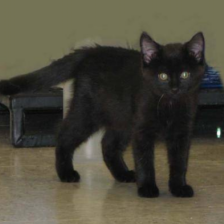

In [293]:
array_cropped = np.transpose(x[0].numpy(), (1,2,0))
array_cropped = 255*(array_cropped+1)/2
img_cropped = Image.fromarray(array_cropped.astype('uint8'), 'RGB')
img_cropped

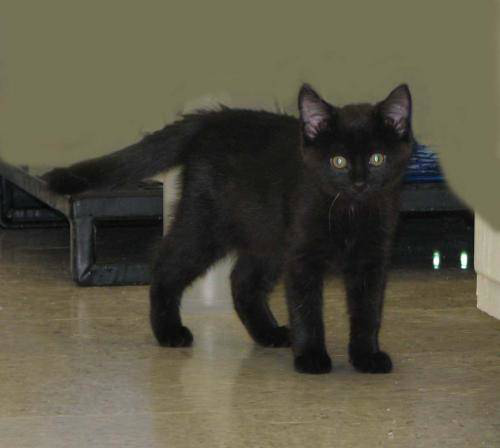

In [294]:
Image.open(test_df[:1].filename[0])

In [297]:
x = read_image(test_df[:1].filename[0]).to(device)
x = torch.unsqueeze(x, dim=0)
x.shape

torch.Size([1, 3, 448, 500])

In [298]:
model_with_preproc(x)

tensor([[0.4488]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [301]:
x = batch["image"].to(device)
x.shape

torch.Size([1, 3, 224, 224])

In [302]:
model(x)

tensor([[0.4488]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
model_filename = f"{save_dir}/{epoch}.pt"

In [303]:
save_dir

'C://Users/SiFuBrO/Desktop/SCRIPTS!!!!!/GitHub/pytorch-base/checkpoints/cats_dogs_classifier_v1/'

In [304]:
model_filename_with_preproc= "C://Users/SiFuBrO/Desktop/SCRIPTS!!!!!/GitHub/pytorch-base/checkpoints/cats_dogs_classifier_v1/model_with_preproc_epc1.tar"

torch.save({
        'epoch': epoch,
        'model_state_dict': model_with_preproc.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'global_step': global_step
    }, model_filename_with_preproc)

In [ ]:
# img_path = test_df.filename[0]
# x = torch.unsqueeze(read_image(img_path), dim=0).to(torch.float).to(device)
# #x = np.expand_dims(np.array(Image.open(img_path)), 0)
# x.shape

## Predict on testset

In [64]:
#TODO: Create a function to run inference on a dataset iterator

total_test_loss = []
test_outputs = []
test_true_labels = []
test_iterator = iter(test_dataloader)

model.eval()
with torch.no_grad():
    for batch in tqdm(test_iterator):
        test_features =  batch["image"].to(device)
        # TODO: log some images in tensorboard
        
        test_labels =  batch["label"].to(device)
        test_output = model(test_features)[0] # from (1,1) [[0.67442]]  to-> (1) i.e., val_output = [0.67442] for examples
        #val_labels is (1,) size i.e, [0] or [1]   

        # validation loss
        test_loss = loss_fn(test_output, test_labels.type(torch.float)).item()
        total_test_loss += [test_loss]
        
        test_outputs += [test_output.item()]  # val_output = [0.67442] for examples 
        test_true_labels += [test_labels.item()]

100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:15<00:00, 165.15it/s]


In [65]:
test_true_labels[:6]

[0, 1, 0, 0, 1, 0]

In [66]:
test_outputs[:6]

[0.45040708780288696,
 0.6275924444198608,
 0.5663313269615173,
 0.4341145157814026,
 0.5830626487731934,
 0.4998098909854889]

In [67]:
test_outputs_binary = (np.array(test_outputs) > 0.5).astype(int)
test_outputs_binary

array([0, 1, 1, ..., 1, 0, 1])

In [68]:
(test_outputs_binary == test_true_labels).sum() / len(test_true_labels) #accuracy 0.6104

0.6104

In [63]:
len(test_outputs)

2500

## Confusion matrix

In [53]:
global_step

158

In [52]:
epoch

1

## Load model
### https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-across-devices
Need to initialize optimizer and model as in training first

In [54]:
optimizer_loaded = torch.optim.Adam(model.parameters(), lr=10**-4, eps=1e-9)

In [55]:
model_loaded = SimpleNet().to(device)

In [56]:
model_filename = "C://Users/SiFuBrO/Desktop/SCRIPTS!!!!!/GitHub/pytorch-base/checkpoints/cats_dogs_classifier_v1/1.pt" #should be .tar
if model_filename:
    print(f'Preloading model {model_filename}')
    state = torch.load(model_filename)
    model_loaded.load_state_dict(state['model_state_dict'])
    initial_epoch_loaded = state['epoch'] + 1
    optimizer_loaded.load_state_dict(state['optimizer_state_dict'])
    global_step_loaded = state['global_step']

Preloading model C://Users/SiFuBrO/Desktop/SCRIPTS!!!!!/GitHub/pytorch-base/checkpoints/cats_dogs_classifier_v1/1.pt


In [57]:
global_step_loaded

158

In [58]:
initial_epoch_loaded

2

In [59]:
optimizer_loaded.state_dict() # same as optimizer.state_dict()

{'state': {0: {'step': tensor(158.),
   'exp_avg': tensor([[[[ 2.1307e-03,  2.2395e-03,  2.4687e-03],
             [ 2.2807e-03,  2.3363e-03,  2.3738e-03],
             [ 2.1934e-03,  2.3157e-03,  2.4980e-03]],
   
            [[ 3.3028e-03,  3.3709e-03,  3.5607e-03],
             [ 3.4920e-03,  3.5042e-03,  3.4996e-03],
             [ 3.4336e-03,  3.5131e-03,  3.6526e-03]],
   
            [[ 4.0172e-03,  4.0486e-03,  4.2095e-03],
             [ 4.2193e-03,  4.1919e-03,  4.1535e-03],
             [ 4.1747e-03,  4.2113e-03,  4.3149e-03]]],
   
   
           [[[ 4.5528e-03,  2.1156e-03,  1.8270e-03],
             [ 4.0821e-03,  2.4405e-03,  2.6869e-03],
             [ 3.5587e-03,  3.2307e-03,  3.2952e-03]],
   
            [[ 4.6100e-03,  2.2442e-03,  2.0401e-03],
             [ 4.1258e-03,  2.5619e-03,  2.8977e-03],
             [ 3.5770e-03,  3.3293e-03,  3.4728e-03]],
   
            [[ 5.4338e-03,  3.0606e-03,  2.8371e-03],
             [ 4.9780e-03,  3.4075e-03,  3.7220e-03],
    

In [60]:
optimizer.state_dict()

{'state': {0: {'step': tensor(158.),
   'exp_avg': tensor([[[[ 2.1307e-03,  2.2395e-03,  2.4687e-03],
             [ 2.2807e-03,  2.3363e-03,  2.3738e-03],
             [ 2.1934e-03,  2.3157e-03,  2.4980e-03]],
   
            [[ 3.3028e-03,  3.3709e-03,  3.5607e-03],
             [ 3.4920e-03,  3.5042e-03,  3.4996e-03],
             [ 3.4336e-03,  3.5131e-03,  3.6526e-03]],
   
            [[ 4.0172e-03,  4.0486e-03,  4.2095e-03],
             [ 4.2193e-03,  4.1919e-03,  4.1535e-03],
             [ 4.1747e-03,  4.2113e-03,  4.3149e-03]]],
   
   
           [[[ 4.5528e-03,  2.1156e-03,  1.8270e-03],
             [ 4.0821e-03,  2.4405e-03,  2.6869e-03],
             [ 3.5587e-03,  3.2307e-03,  3.2952e-03]],
   
            [[ 4.6100e-03,  2.2442e-03,  2.0401e-03],
             [ 4.1258e-03,  2.5619e-03,  2.8977e-03],
             [ 3.5770e-03,  3.3293e-03,  3.4728e-03]],
   
            [[ 5.4338e-03,  3.0606e-03,  2.8371e-03],
             [ 4.9780e-03,  3.4075e-03,  3.7220e-03],
    

## Torchscript

In [61]:
model_scripted = torch.jit.script(model)
model_scripted.save("C://Users/SiFuBrO/Desktop/SCRIPTS!!!!!/GitHub/pytorch-base/checkpoints/cats_dogs_classifier_v1/model_scripted_epc1.pt")

In [62]:
model_scripted_loaded = torch.jit.load('C://Users/SiFuBrO/Desktop/SCRIPTS!!!!!/GitHub/pytorch-base/checkpoints/cats_dogs_classifier_v1/model_scripted_epc1.pt')
model_scripted_loaded.eval()

RecursiveScriptModule(
  original_name=SimpleNet
  (conv1): RecursiveScriptModule(original_name=Conv2d)
  (pool): RecursiveScriptModule(original_name=MaxPool2d)
  (conv2): RecursiveScriptModule(original_name=Conv2d)
  (conv3): RecursiveScriptModule(original_name=Conv2d)
  (conv4): RecursiveScriptModule(original_name=Conv2d)
  (global_avg_pool): RecursiveScriptModule(original_name=AdaptiveAvgPool2d)
  (fc1): RecursiveScriptModule(original_name=Linear)
  (fc2): RecursiveScriptModule(original_name=Linear)
)

In [77]:
def prepare_image_for_inference(img_path, transform):
    image = read_image(img_path)
    # do test transforms
    image = transform(image)
    # add batch dimension
    image = torch.unsqueeze(image, dim=0)
    return image

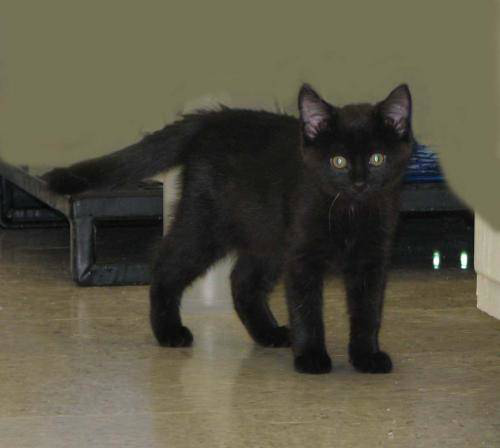

In [78]:
from PIL import Image
Image.open(test_df.filename[0])

In [79]:
img_tensor = prepare_image_for_inference(test_df.filename[0], transforms_test_valid)
img_tensor.shape

torch.Size([1, 3, 224, 224])

In [81]:
img_tensor = img_tensor.to(device) # move to same devide (aka cuda)
model_scripted_loaded(img_tensor)

tensor([[0.4488]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [305]:
test_df.filename[0]

'D://DATASETS/DogsVsCats/train-val-test\\cat.3880.jpg'

In [86]:
scripted_preds = []

model.eval()

test_iterator = iter(test_dataloader)
with torch.no_grad():
    for batch in tqdm(test_iterator):
        test_features =  batch["image"].to(device)
        scripted_preds.append(model_scripted_loaded(test_features).item())

100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:13<00:00, 187.88it/s]


In [87]:
scripted_preds # same as test_outputs

[0.45040708780288696,
 0.6275924444198608,
 0.5663313269615173,
 0.4341145157814026,
 0.5830626487731934,
 0.4998098909854889,
 0.4678643047809601,
 0.6071937084197998,
 0.6597334146499634,
 0.4435884654521942,
 0.5784118175506592,
 0.4319060742855072,
 0.5036275386810303,
 0.5382791757583618,
 0.5731017589569092,
 0.6721858978271484,
 0.6550880670547485,
 0.5324430465698242,
 0.5149796009063721,
 0.5910705327987671,
 0.6461492776870728,
 0.5055290460586548,
 0.45347705483436584,
 0.5390981435775757,
 0.5158787965774536,
 0.6370501518249512,
 0.5939291715621948,
 0.5945863723754883,
 0.454840749502182,
 0.5241515636444092,
 0.48535802960395813,
 0.7620522975921631,
 0.6718275547027588,
 0.578071117401123,
 0.5182846784591675,
 0.6725680828094482,
 0.5319197773933411,
 0.5333040356636047,
 0.5529943704605103,
 0.5023229122161865,
 0.5884549617767334,
 0.5068346261978149,
 0.5238074064254761,
 0.5849360227584839,
 0.5429211854934692,
 0.4755534827709198,
 0.48228728771209717,
 0.71378231

In [82]:
test_outputs

[0.45040708780288696,
 0.6275924444198608,
 0.5663313269615173,
 0.4341145157814026,
 0.5830626487731934,
 0.4998098909854889,
 0.4678643047809601,
 0.6071937084197998,
 0.6597334146499634,
 0.4435884654521942,
 0.5784118175506592,
 0.4319060742855072,
 0.5036275386810303,
 0.5382791757583618,
 0.5731017589569092,
 0.6721858978271484,
 0.6550880670547485,
 0.5324430465698242,
 0.5149796009063721,
 0.5910705327987671,
 0.6461492776870728,
 0.5055290460586548,
 0.45347705483436584,
 0.5390981435775757,
 0.5158787965774536,
 0.6370501518249512,
 0.5939291715621948,
 0.5945863723754883,
 0.454840749502182,
 0.5241515636444092,
 0.48535802960395813,
 0.7620522975921631,
 0.6718275547027588,
 0.578071117401123,
 0.5182846784591675,
 0.6725680828094482,
 0.5319197773933411,
 0.5333040356636047,
 0.5529943704605103,
 0.5023229122161865,
 0.5884549617767334,
 0.5068346261978149,
 0.5238074064254761,
 0.5849360227584839,
 0.5429211854934692,
 0.4755534827709198,
 0.48228728771209717,
 0.71378231

## Multi gpu training

## Mixed precision

## Custom Training loop in pytorch

## ONNX runtime

### https://pytorch.org/tutorials/advanced/super_resolution_with_onnxruntime.html

pip install onnx onnxruntime

## Export torch model ONNX

### https://pytorch.org/docs/master/onnx.html

#### It is important to call torch_model.eval() or torch_model.train(False) before exporting the model, to turn the model to inference mode. This is required since operators like dropout or batchnorm behave differently in inference and training mode

In [ ]:
# Load pretrained model weights
model_url = 'https://s3.amazonaws.com/pytorch/test_data/export/superres_epoch100-44c6958e.pth'
batch_size = 1    # just a random number

# Initialize model with the pretrained weights
map_location = lambda storage, loc: storage
if torch.cuda.is_available():
    map_location = None
torch_model.load_state_dict(model_zoo.load_url(model_url, map_location=map_location))

# set the model to inference mode
torch_model.eval()

## Tracing

execute model --> recoding trace of operations to comput outputs

Because export runs the model, we need to provide an input tensor x

Note that the input size will be fixed in the exported ONNX graph for all the input’s dimensions, unless specified as a dynamic axes

In [89]:
model.eval()

SimpleNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (global_avg_pool): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=128, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

In [91]:
# Input to the model
batch_size = 1
height = 224
width = 224

onnx_model_path = "C://Users/SiFuBrO/Desktop/SCRIPTS!!!!!/GitHub/pytorch-base/checkpoints/cats_dogs_classifier_v1/onnx_model_epc1.onnx"

x = torch.randn(batch_size, 3, height , width, requires_grad=True).to(device)
torch_out = model(x)

# Export the model
torch.onnx.export(model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  onnx_model_path,   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size', 2: 'height', 3: 'width'},    # variable length axes
                                'output' : {0 : 'batch_size', 2: 'height', 3: 'width'}})

In [92]:
import onnx

onnx_model = onnx.load(onnx_model_path)
onnx.checker.check_model(onnx_model)

### Now let’s compute the output using ONNX Runtime’s Python APIs

This part can normally be done in a separate process or on another machine, but we will continue in the same process so that we can verify that ONNX Runtime and PyTorch are computing the same value for the network.


In order to run the model with ONNX Runtime, we need to create an inference session for the model with the chosen configuration parameters (here we use the default config). Once the session is created, we evaluate the model using the run() API. The output of this call is a list containing the outputs of the model computed by ONNX Runtime.

In [94]:
import onnxruntime

ort_session = onnxruntime.InferenceSession(onnx_model_path, providers=["CPUExecutionProvider"])
ort_session

In [95]:
ort_session.get_inputs()

In [96]:
ort_session.get_inputs()[0].name

'input'

In [98]:
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

In [99]:
# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)
ort_outs

[array([[2.9219553]], dtype=float32)]

In [100]:
torch_out

tensor([[2.9219]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [101]:
# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

## Include preprocessing in model export

In [160]:
# results in error during scriptin
class PreprocessingModule(torch.nn.Module):
    def __init__(self):
        super(PreprocessingModule, self).__init__()
        self.transform = transforms.Compose([
                                #transforms.ToTensor(),
                                Normalize(),
                                transforms.Resize(256),
                                transforms.CenterCrop(224)
                                ])
    
    def forward(self, input_image):
        # Apply preprocessing transforms to input_image
        preprocessed_image = self.transform(input_image)
        return preprocessed_image

In [220]:
#import  torchvision.transforms.InterpolationMode  as InterpolationMode
from torchvision.transforms.functional import _interpolation_modes_from_int, InterpolationMode
from collections.abc import Sequence
from torchvision.transforms import functional as F_trans

class PreprocessingModule(torch.nn.Module):
    def __init__(self, size=256, interpolation=InterpolationMode.BILINEAR, max_size= None, antialias=True):
        super(PreprocessingModule, self).__init__()
        if not isinstance(size, (int, Sequence)):
            raise TypeError(f"Size should be int or sequence. Got {type(size)}")
        if isinstance(size, Sequence) and len(size) not in (1, 2):
            raise ValueError("If size is a sequence, it should have 1 or 2 values")
        self.size = [size, size]
        self.max_size = max_size

        if isinstance(interpolation, int):
            interpolation = _interpolation_modes_from_int(interpolation)

        self.interpolation = interpolation
        self.antialias = antialias
    
    def forward(self, input_image):
        # Apply preprocessing transforms to input_image
        # Normalize image (assuming input_image is already in range [0, 1])
        preprocessed_image =  2*(input_image/255.0) - 1  # Example normalization
        
        # Resize and CenterCrop using torch.nn.functional.interpolate
        # Resize to 256x256
        preprocessed_image = F_trans.resize(preprocessed_image, self.size, self.interpolation, self.max_size, self.antialias)
        # CenterCrop to 224x224
        preprocessed_image = preprocessed_image[:, :, 16:240, 16:240]  # Assuming input_image is BxCxHxW
        return preprocessed_image

In [221]:
class ModelWithPreproc(torch.nn.Module):
    def __init__(self, conv_net):
        super(ModelWithPreproc, self).__init__()
        self.preprocess = PreprocessingModule()
        self.conv_net = conv_net
    
    def forward(self, input_image):
        # Preprocess input image using the PreprocessingModule
        preprocessed_image = self.preprocess(input_image)
        
        # Pass preprocessed image through the convolutional network
        output = self.conv_net(preprocessed_image)
        return output

model_with_preproc = ModelWithPreproc(model)
model_with_preproc.eval()

ModelWithPreproc(
  (preprocess): PreprocessingModule()
  (conv_net): SimpleNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (global_avg_pool): AdaptiveAvgPool2d(output_size=1)
    (fc1): Linear(in_features=128, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [215]:
model_with_preproc_scripted = torch.jit.script(model_with_preproc) # Export to TorchScript
model_with_preproc_scripted.save('C://Users/SiFuBrO/Desktop/SCRIPTS!!!!!/GitHub/pytorch-base/checkpoints/cats_dogs_classifier_v1/model_with_preproc_scripted.pt') # Save

In [216]:
img_path = test_df.filename[0]
x = torch.unsqueeze(read_image(img_path), dim=0).to(torch.float).to(device)
#x = np.expand_dims(np.array(Image.open(img_path)), 0)
x.shape

torch.Size([1, 3, 448, 500])

### https://github.com/pytorch/vision/issues/4902

In [217]:
## Another issue with 

In [219]:
model_with_preproc(x)  #should have been [[4488]]

tensor([[0.4544]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [218]:
onnx_model_path_with_preproc = "C://Users/SiFuBrO/Desktop/SCRIPTS!!!!!/GitHub/pytorch-base/checkpoints/cats_dogs_classifier_v1/onnx_model_with_preproc_epc1.onnx"

torch_out_with_preproc = model_with_preproc(x)

# Export the model
torch.onnx.export(model_with_preproc_scripted,               # model being run (needs to be scripted due to CenterCrop)
                  x,                         # model input (or a tuple for multiple inputs)
                  onnx_model_path_with_preproc,   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=11,          # the ONNX version to export the model to  (default 10)
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size', 2: 'height', 3: 'width'},    # variable length axes
                                'output' : {0 : 'batch_size', 2: 'height', 3: 'width'}})

SymbolicValueError: ONNX symbolic expected node type prim::ListConstruct, got '%19 : Long(2, strides=[1], device=cpu) = onnx::Constant[value= 6  7 [ CPULongType{2} ]]()
'.  [Caused by the value '19 defined in (%19 : Long(2, strides=[1], device=cpu) = onnx::Constant[value= 6  7 [ CPULongType{2} ]]()
)' (type 'Tensor') in the TorchScript graph. The containing node has kind 'onnx::Constant'.] 

    Inputs:
        Empty
    Outputs:
        #0: 19 defined in (%19 : Long(2, strides=[1], device=cpu) = onnx::Constant[value= 6  7 [ CPULongType{2} ]]()
    )  (type 'Tensor')

In [210]:
import onnx

onnx_model_with_preproc = onnx.load(onnx_model_path_with_preproc)
onnx.checker.check_model(onnx_model_with_preproc)

In [178]:
ort_session_with_preproc = onnxruntime.InferenceSession(onnx_model_path_with_preproc, providers=["CPUExecutionProvider"])

# compute ONNX Runtime output prediction
ort_inputs = {ort_session_with_preproc.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session_with_preproc.run(None, ort_inputs)
ort_outs

[array([[0.40188563]], dtype=float32)]

In [179]:
img_path = test_df.filename[0]
x = torch.unsqueeze(read_image(img_path), dim=0).to(torch.float).to(device)
x.shape

torch.Size([1, 3, 448, 500])

In [180]:
x = Normalize()(x)
x = transforms.Resize(256)(x)
x = transforms.CenterCrop(224)(x)
x

tensor([[[[-0.0902, -0.0902, -0.0902,  ..., -0.0902, -0.0902, -0.0902],
          [-0.0902, -0.0902, -0.0902,  ..., -0.0902, -0.0902, -0.0902],
          [-0.0902, -0.0902, -0.0902,  ..., -0.0902, -0.0902, -0.0902],
          ...,
          [ 0.1254,  0.1242,  0.1408,  ..., -0.0237, -0.0191, -0.0170],
          [ 0.1621,  0.1472,  0.1264,  ..., -0.0930, -0.0675, -0.0439],
          [ 0.1366,  0.1299,  0.1322,  ..., -0.0464, -0.0606, -0.0651]],

         [[-0.0980, -0.0980, -0.0980,  ..., -0.0980, -0.0980, -0.0980],
          [-0.0980, -0.0980, -0.0980,  ..., -0.0980, -0.0980, -0.0980],
          [-0.0980, -0.0980, -0.0980,  ..., -0.0980, -0.0980, -0.0980],
          ...,
          [ 0.0767,  0.0783,  0.0954,  ..., -0.0800, -0.0754, -0.0733],
          [ 0.0897,  0.0835,  0.0598,  ..., -0.1375, -0.1121, -0.0885],
          [ 0.0619,  0.0658,  0.0636,  ..., -0.1006, -0.1148, -0.1193]],

         [[-0.3333, -0.3333, -0.3333,  ..., -0.3333, -0.3333, -0.3333],
          [-0.3333, -0.3333, -

In [181]:
model(x)

tensor([[0.4488]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [182]:
# onnx_model
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)
ort_outs

[array([[0.44880962]], dtype=float32)]

## Tracing & scripting

## Docker serve torch model

## Freeze model and train particular parameters

## Resume Training

## Warm start by loading some parameters and freezing others

## Visualize Conv Blocks

## Train Vision Transformers

### https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/11-vision-transformer.html

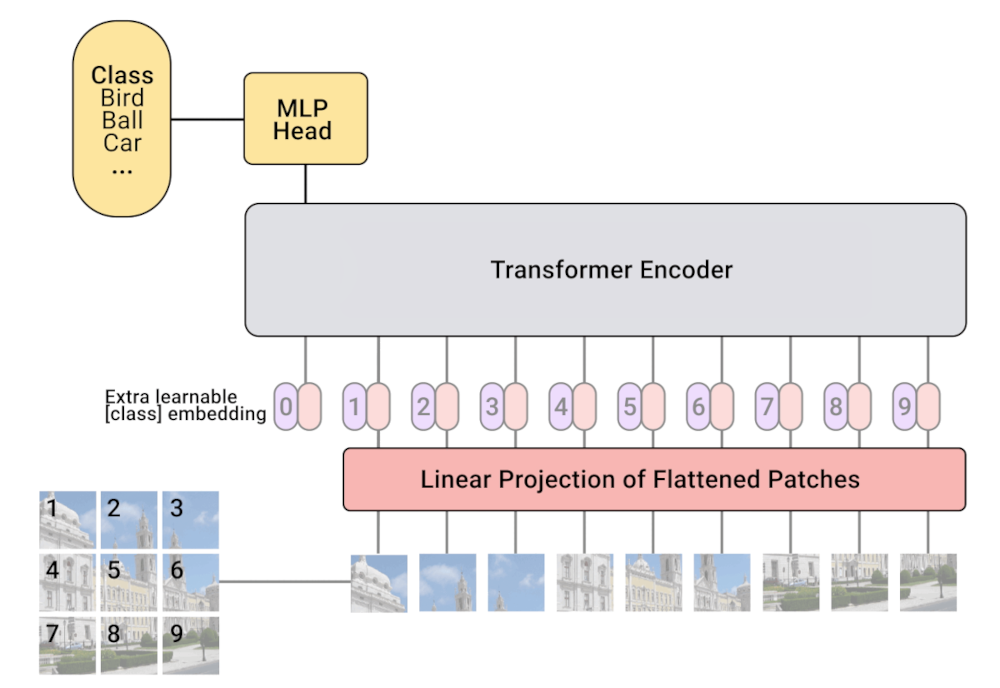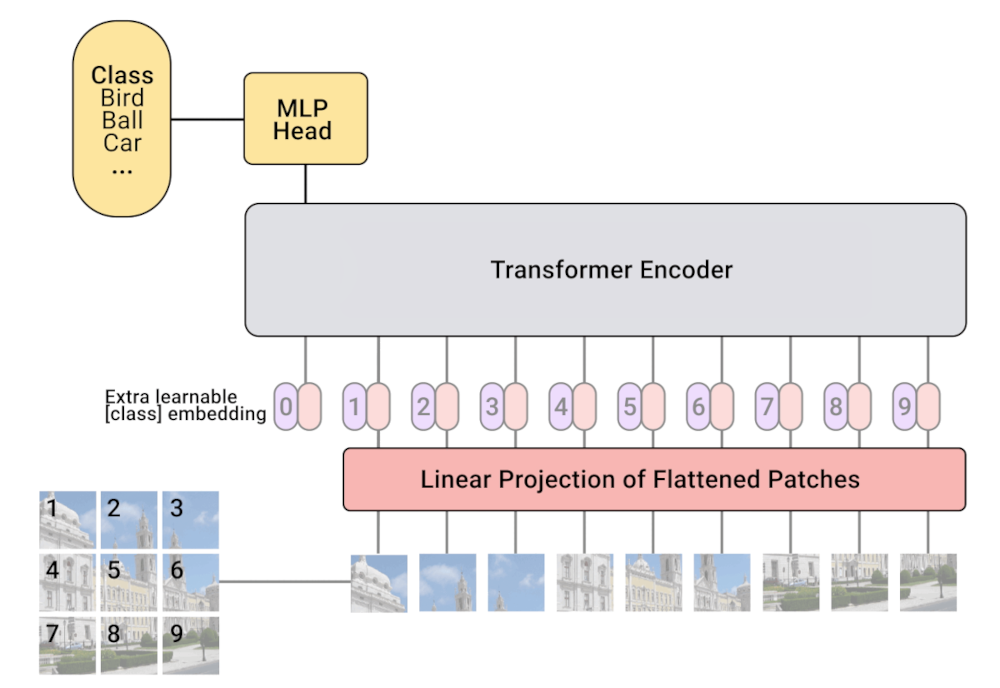

### An image of size NxN can be split into $(N/M)^2$ patches of size MxM. These represent the input "words" to the Transformer.

In [ ]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Args:
        x: Tensor representing the image of shape [B, C, H, W]
        patch_size: Number of pixels per dimension of the patches (integer)
        flatten_channels: If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape
    x = x.reshape(B, C, H // patch_size, patch_size, W // patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5)  # [B, H', W', C, p_H, p_W]
    x = x.flatten(1, 2)  # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2, 4)  # [B, H'*W', C*p_H*p_W]
    return x

In [327]:
img_path = test_df.filename[0]
x = torch.unsqueeze(read_image(img_path), dim=0).to(torch.float).to(device)
# x.shape = torch.Size([1, 3, 448, 500])

x = Normalize()(x)
x = transforms.Resize(256)(x)
x = transforms.CenterCrop(224)(x)  #torch.Size([1, 3, 224, 224])
x.shape

torch.Size([1, 3, 224, 224])

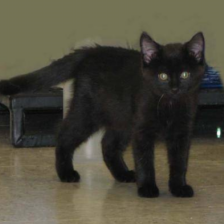

In [328]:
numpy_image = np.transpose(x[0].cpu().numpy(), (1,2,0) )
numpy_image = 255*(numpy_image + 1)/2
PIL_image = Image.fromarray(numpy_image.astype('uint8'), 'RGB')
PIL_image

### 224x224 image --> Split into 32x32 image patches --> 7*7=49 patches in total

In [329]:
patch_size = 32
B, C, H, W = x.shape
B, C, H, W

(1, 3, 224, 224)

In [330]:
7*32

224

In [331]:
x = x.reshape(B, C, H // patch_size, patch_size, W // patch_size, patch_size)
x.shape

torch.Size([1, 3, 7, 32, 7, 32])

In [332]:
x = x.permute(0, 2, 4, 1, 3, 5)  # [B, H', W', C, p_H, p_W]
x.shape

torch.Size([1, 7, 7, 3, 32, 32])

In [333]:
x = x.flatten(1, 2)
x.shape

torch.Size([1, 49, 3, 32, 32])

In [338]:
## Visualize patches
def visualize_patches(tensor):
    tensor = torch.squeeze(tensor)
    f, ax = plt.subplots(7,7, figsize=(12,12))
    for row in range(7):
        for col in range(7):
            img = tensor[7*row + col,:,:,:].detach().cpu().numpy()  # (3, 32, 32)
            img = 255*(img+1)/2 # reverse preprocessing
            img = np.transpose(img, (1,2,0)) # (32, 32, 3)
            img = Image.fromarray(img.astype('uint8'), 'RGB')
            ax[row,col].imshow(img)
    plt.show()

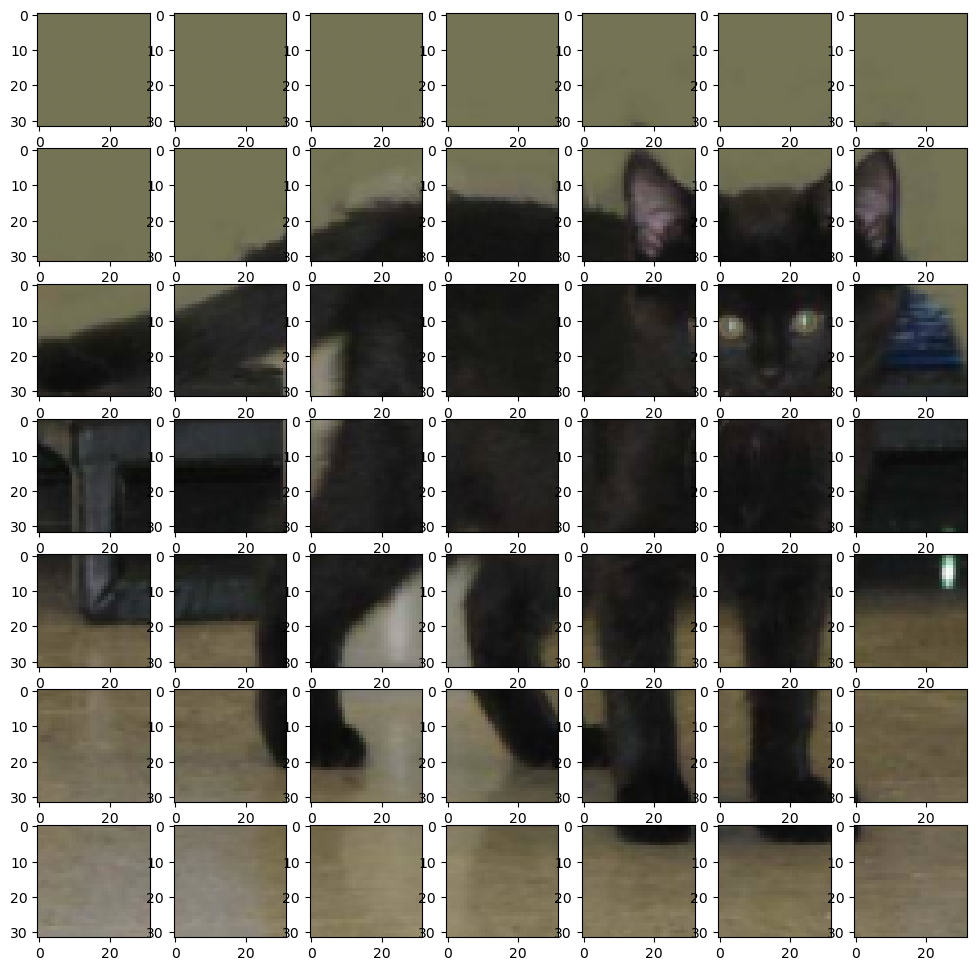

In [339]:
visualize_patches(x)

In [342]:
# Flattent the patches
32 * 32 * 3

3072

In [340]:
# Flattent the patches
x = x.flatten(2, 4)
x.shape

torch.Size([1, 49, 3072])

## ViT
### https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/11-vision-transformer.html
### https://github.com/sifubro/pytorch-transformer/blob/main/model.py

In [345]:
class MultiHeadAttentionBlock(nn.Module):
    '''
    https://github.com/sifubro/pytorch-transformer/blob/main/model.py
    '''

    def __init__(self, d_model: int, h: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model # Embedding vector size
        self.h = h # Number of heads
        # Make sure d_model is divisible by h
        assert d_model % h == 0, "d_model is not divisible by h"

        self.d_k = d_model // h # Dimension of vector seen by each head
        self.w_q = nn.Linear(d_model, d_model, bias=False) # Wq
        self.w_k = nn.Linear(d_model, d_model, bias=False) # Wk
        self.w_v = nn.Linear(d_model, d_model, bias=False) # Wv
        self.w_o = nn.Linear(d_model, d_model, bias=False) # Wo
        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):
        d_k = query.shape[-1]
        # Just apply the formula from the paper
        # (batch, h, seq_len, d_k) --> (batch, h, seq_len, seq_len)
        attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            # Write a very low value (indicating -inf) to the positions where mask == 0
            attention_scores.masked_fill_(mask == 0, -1e9)
        attention_scores = attention_scores.softmax(dim=-1) # (batch, h, seq_len, seq_len) # Apply softmax
        if dropout is not None:
            attention_scores = dropout(attention_scores)
        # (batch, h, seq_len, seq_len) --> (batch, h, seq_len, d_k)
        # return attention scores which can be used for visualization
        return (attention_scores @ value), attention_scores

    def forward(self, q, k, v, mask):
        query = self.w_q(q) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        key = self.w_k(k) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        value = self.w_v(v) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)

        # (batch, seq_len, d_model) --> (batch, seq_len, h, d_k) --> (batch, h, seq_len, d_k)
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)

        # Calculate attention
        x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)
        
        # Combine all the heads together
        # (batch, h, seq_len, d_k) --> (batch, seq_len, h, d_k) --> (batch, seq_len, d_model)
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

        # Multiply by Wo
        # (batch, seq_len, d_model) --> (batch, seq_len, d_model)  
        return self.w_o(x)

## The implementation of the Pre-LN attention block looks as follows:

In [346]:
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """Attention Block.
        https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/11-vision-transformer.html

        Args:
            embed_dim: Dimensionality of input and attention feature vectors
            hidden_dim: Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads: Number of heads to use in the Multi-Head Attention block
            dropout: Amount of dropout to apply in the feed-forward network
        """
        super().__init__()
        # pre-layer 
        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        #self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        # Implement custom MultiHeadAttention
        self.attn = MultiHeadAttentionBlock(embed_dim, num_heads)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

### Now we have all modules ready to build our own Vision Transformer. Besides the Transformer encoder, we need the following modules:

- A **linear projection layer that maps the input patches to a feature vector of larger size**. It is implemented by a simple linear layer that takes each M\times M patch independently as input.

- A **classification token that is added to the input sequence**. We will use the output feature vector of the classification token (CLS token in short) for determining the classification prediction.

- **Learnable positional encodings** that are added to the tokens before being processed by the Transformer. Those are needed to learn position-dependent information, and convert the set to a sequence. Since we usually work with a fixed resolution, we can learn the positional encodings instead of having the pattern of sine and cosine functions.

- **A MLP head that takes the output feature vector of the CLS token, and maps it to a classification prediction**. This is usually implemented by a small feed-forward network or even a single linear layer.

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        embed_dim,
        hidden_dim,
        num_channels,
        num_heads,
        num_layers,
        num_classes,
        patch_size,
        num_patches,
        dropout=0.0,
    ):
        """Vision Transformer.

        Args:
            embed_dim: Dimensionality of the input feature vectors to the Transformer
            hidden_dim: Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels: Number of channels of the input (3 for RGB)
            num_heads: Number of heads to use in the Multi-Head Attention block
            num_layers: Number of layers to use in the Transformer
            num_classes: Number of classes to predict
            patch_size: Number of pixels that the patches have per dimension
            num_patches: Maximum number of patches an image can have
            dropout: Amount of dropout to apply in the feed-forward network and
                      on the input encoding
        """
        super().__init__()

        self.patch_size = patch_size

        # Layers/Networks
        self.input_layer = nn.Linear(num_channels * (patch_size**2), embed_dim)
        self.transformer = nn.Sequential(
            *(AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers))
        )
        self.mlp_head = nn.Sequential(nn.LayerNorm(embed_dim), nn.Linear(embed_dim, num_classes))
        self.dropout = nn.Dropout(dropout)

        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))

    def forward(self, x):
        # Preprocess input
        x = img_to_patch(x, self.patch_size)
        B, T, _ = x.shape
        x = self.input_layer(x)

        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = x + self.pos_embedding[:, : T + 1]

        # Apply Transforrmer
        x = self.dropout(x)
        x = x.transpose(0, 1)
        x = self.transformer(x)

        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out

In [343]:
array1 = ["a", "b", "c"]
array2 = [1,2,3]

array_zip = zip(array1, array2)
for elem in array_zip:
    print(elem)

('a', 1)
('b', 2)
('c', 3)


## Visualize Attention

TODO: How can I visualize pytorch MultiHeadAttention implementation?

## Views

In [321]:
t = torch.rand(4, 4)
t

tensor([[0.4528, 0.0218, 0.6495, 0.3753],
        [0.0739, 0.3662, 0.6933, 0.6026],
        [0.7668, 0.5476, 0.1332, 0.4344],
        [0.7739, 0.0743, 0.4943, 0.6711]])

In [322]:
b = t.view(2, 8)
b

tensor([[0.4528, 0.0218, 0.6495, 0.3753, 0.0739, 0.3662, 0.6933, 0.6026],
        [0.7668, 0.5476, 0.1332, 0.4344, 0.7739, 0.0743, 0.4943, 0.6711]])

## Contiguous Tensor

In [ ]:
## conda create -n torch_gpu python=3.8 anaconda
## conda activate torch_gpu
## pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

## TODO: Tensorboard


In [ ]:
def get_config():
    return {
        "batch_size": 8,
        "num_epochs": 20,
        "lr": 10**-4,
        "seq_len": 350,
        "d_model": 512,
        "datasource": 'opus_books',
        "lang_src": "en",
        "lang_tgt": "it",
        "model_folder": "weights",
        "model_basename": "tmodel_",
        "preload": "latest",
        "tokenizer_file": "tokenizer_{0}.json",
        "experiment_name": "runs/tmodel"
    }

In [59]:
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)

target.shape, input.shape

(torch.Size([3]), torch.Size([3, 5]))

## TODOS:
- Multi gpu training
- Load model and resume training
- Freeze part of the model and train the rest
- Initialize custom model
- Testing with batches (not batch=1)
- Type checking
- Annotations
- 